# Google Earth Engine Imagery Tests

Notes on Authentication:
User needs to sign up with Google Earth Engine and recieve a confirmation email before connecting to the API

In [7]:
# Import the Python API
import ee
print("API Version:", ee.__version__)

API Version: 0.1.265


In [8]:
# Authenticate, Initialize
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [ ]:
# Synchronize time with Machine

import datetime
ee_date = ee.Date('2020-01-01')
py_date = datetime.datetime.utcfromtimestamp(ee_date.getInfo()['value']/1000.0)

In [10]:
# Load an example image

loaded_image = ee.Image('JAXA/ALOS/AW3D30/V2_2')
type(loaded_image)

ee.image.Image

In [25]:
import sys
import numpy as np

uri = ('gs://gcp-public-data-landsat/LC08/01/001/002/'
       'LC08_L1GT_001002_20160817_20170322_01_T2/'
       'LC08_L1GT_001002_20160817_20170322_01_T2_B5.TIF')
cloud_image = ee.Image.loadGeoTIFF(uri)

print(type(cloud_image))
print(cloud_image.getInfo())


print("RESAMPLED:\n", resampled.getBounds())

sys.exit(0)

# Parse Bands
band_01 = sample_area.get('B1')
band_02 = sample_area.get('B2')

# Convert to numpy arrays
np_01 = np.array(band_01.getInfo())
np_02 = np.array(band_02.getInfo())

print(np_01)

<class 'ee.image.Image'>
{'type': 'Image', 'bands': [{'id': 'B0', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [8991, 8971], 'crs': 'EPSG:32630', 'crs_transform': [30, 0, 342000, 0, -30, 9016200]}]}


AttributeError: 'Image' object has no attribute 'getBounds'

In [21]:
print(sample.get('B1'))

ee.ComputedObject({
  "functionInvocationValue": {
    "functionName": "Element.get",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Image.sampleRectangle",
          "arguments": {
            "image": {
              "functionInvocationValue": {
                "functionName": "Image.loadGeoTIFF",
                "arguments": {
                  "uri": {
                    "constantValue": "gs://gcp-public-data-landsat/LC08/01/001/002/LC08_L1GT_001002_20160817_20170322_01_T2/LC08_L1GT_001002_20160817_20170322_01_T2_B5.TIF"
                  }
                }
              }
            }
          }
        }
      },
      "property": {
        "constantValue": "B1"
      }
    }
  }
})


### Map with Leaflet (Folium)

In [18]:
# Python library for folium maps
import folium

first = (ee.ImageCollection('COPERNICUS/S2_SR')
         .filterBounds(ee.Geometry.Point(-70.48, 43.3631))
         .filterDate('2019-01-01', '2019-12-31')
         .sort('CLOUDY_PIXEL_PERCENTAGE')
         .first())

# Define a map centered on southern Maine.
map_s2 = folium.Map(location=[43.7516, -70.8155], zoom_start=11)

# Add the image layer to the map and display it.
map_s2.add_child(
    first, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}, 'first')
display(map_s2)

ValueError: invalid literal for int() with base 10: 'first'

# Earth Engine to Numpy

Example provided by [**OpenGeoBlog**](https://mygeoblog.com/2019/08/21/google-earth-engine-to-numpy/)

 number of image:  20


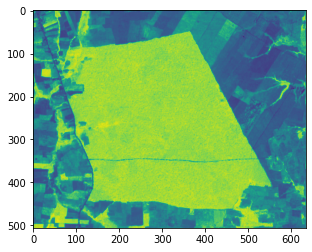

In [27]:
 
# Define the roi
area = ee.Geometry.Polygon([[105.4084512289977,12.960956032145036],\
                            [105.46544280614614,12.960956032145036],\
                            [105.46544280614614,13.006454200439705],\
                            [105.4084512289977,13.006454200439705],\
                            [105.4084512289977,12.960956032145036]])
 
# define the image
collection = ee.ImageCollection("COPERNICUS/S2").filterBounds(area)\
                                      .filterDate("2018-01-01","2019-01-10")\
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",10)\
                                      .select(['B8', 'B4'])
 
print(" number of image: ",collection.size().getInfo())
 
# perform any calculation on the image collection here
def anyFunction(img):
    ndvi = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return ndvi
 
# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
 
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);
 
    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data
 
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr
 
# map over the image collection
myCollection  = collection.map(anyFunction)
 
# get the median
result = ee.Image(myCollection.median()).rename(['result'])
 
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(result)
 
# 1d to 2d array
image  = toImage(lat,lon,data)
 
# in case you want to plot the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()